# Descriptive Analysis

In order to get a better understanding on the taxi usage in Chicago, the taxi trip data is analyzed in this notebook. 

The data on Chicago's census tract used during the anaylsis were downloaded from: 

For more information on how the POI data was sourced, please refer to the poi_cleaning.ipynb notebook. 

#### Imports and Preparation

In [44]:
#importing all relevant libraries used during the analysis
import pandas as pd
import numpy as np

import folium
import seaborn as sns
import matplotlib.pyplot as plt
import h3
import geopandas as gpd
import branca.colormap as cm
import shapely
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon

In [3]:
#load taxi trip data
taxi_trips_df = pd.read_csv(f"trips_chicago_2019.csv")

In [4]:
#load census tract border data from the city of chicago
census_tracts = gpd.read_file(f'census_tracts.geojson')

In [5]:
#prepare census tract data
census_tracts = census_tracts.rename({"geoid10": "geo_id", "name10": "census_tract_short"}, axis=1)
census_tracts = census_tracts.filter(['geo_id', 'census_tract_short', 'geometry'])
census_tracts['geometry'] = census_tracts['geometry'].to_crs('EPSG:4326')
census_tracts['centroids'] = census_tracts["geometry"].centroid

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_11389/1101301741.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  census_tracts['centroids'] = census_tracts["geometry"].centroid


In [6]:
#change census tract feature in the taxi trip data to fit the census tract data from the city of chicago
taxi_trips_df['Pickup Census Tract'] = taxi_trips_df['Pickup Census Tract'].apply(lambda x: str(x).split('.')[0][:12])
taxi_trips_df['Dropoff Census Tract'] = taxi_trips_df['Dropoff Census Tract'].apply(lambda x: str(x).split('.')[0][:12])

#### can be deleted if cleaned data is used?

In [7]:
#convert date-related columns to datetime
taxi_trips_df['Trip Start Timestamp'] = pd.to_datetime(taxi_trips_df['Trip Start Timestamp'])
taxi_trips_df['Trip End Timestamp'] = pd.to_datetime(taxi_trips_df['Trip End Timestamp'])

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_11389/2872298785.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  taxi_trips_df['Trip Start Timestamp'] = pd.to_datetime(taxi_trips_df['Trip Start Timestamp'])
/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_11389/2872298785.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  taxi_trips_df['Trip End Timestamp'] = pd.to_datetime(taxi_trips_df['Trip End Timestamp'])


#### Idle Time Calculation (move this to the Data Preparation Notebook?)

In [8]:
#drop rows with empty time stamps
taxi_trips_df.dropna(subset=['Trip End Timestamp', 'Trip Start Timestamp'], axis=0, inplace=True)

In [10]:
#set index to combination of initial index and taxi ID to facilitate the computation of the idle time between two trips for a taxi
taxi_trips_df= taxi_trips_df.sort_values(by=['Trip Start Timestamp', 'Trip End Timestamp'])
taxi_trips_df.reset_index(drop=True, inplace=True)
taxi_trips_df.set_index(['Taxi ID', taxi_trips_df.index], inplace=True)
taxi_trips_df.sort_index(inplace=True)


In [11]:
#compute idle time between trips
#takes almost 4 minutes
idle_times = pd.Series()
for id in taxi_trips_df.index.get_level_values(0).unique():
    current_taxi = taxi_trips_df.loc[id]
    current_taxi = current_taxi.assign(idle_time = lambda x: x['Trip Start Timestamp'] - x['Trip End Timestamp'].shift(1))
    idle_time_taxi = current_taxi['idle_time']
    idle_times =  pd.concat([idle_times, idle_time_taxi])

idle_times = idle_times.dt.total_seconds()
taxi_trips_df.set_index([taxi_trips_df.index.get_level_values(1)], inplace=True)
    

taxi_trips_df['idle_seconds'] = idle_times
#maybe also consider the end of the work day... taxi drivers dont drive for 24h 

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_11389/2380545702.py:7: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  idle_times =  pd.concat([idle_times, idle_time_taxi])


In [12]:
#check for negative values as this should not be the case
print(len(taxi_trips_df[taxi_trips_df['idle_seconds'] < 0 ]))
taxi_trips_df[taxi_trips_df['idle_seconds'] < 0]
# drop negative value trips
taxi_trips_df = taxi_trips_df[taxi_trips_df['idle_seconds'] >= 0]

47441


#### Data Preparation for H3 Hexagons (should be moved to Data Cleaning & Preparation Notebook)

In [13]:
#calculate hexagon for each census tracts based on different hexagon resolutions (4-9)
for i in range(4,10):
    census_tracts[f'h3_{i}'] = census_tracts['centroids'].apply(lambda x: h3.geo_to_h3(x.y, x.x, resolution=i))

#### Trip Count Calculation for Pickup and Dropoff per Census Tract

In [14]:
#count trips in total for pickup and dropoff location 
trip_counts = (
    taxi_trips_df['Pickup Census Tract'].value_counts()
    .reset_index()
    .rename(columns={'Pickup Census Tract': 'geo_id', 'count':'pickup_count'})
    .merge(
        taxi_trips_df['Dropoff Census Tract'].value_counts()
        .reset_index()
        .rename(columns={'Dropoff Census Tract': 'geo_id', 'count':'dropoff_count'}),
        on='geo_id',
        how='outer'
    )
    .fillna(0)
)

#merge census tracts and trip_count data 
trip_counts = pd.merge(census_tracts, trip_counts, left_on="geo_id", right_on='geo_id', how='left')
trip_counts = gpd.GeoDataFrame(trip_counts, geometry="geometry")

In [15]:
def get_basic_info_about_feature(stri):
    print(f"maximum number of trips in a census tract: {trip_counts[stri].max()}\naverage number of trips in a census tract: {trip_counts[stri].mean()}\nminimum number of trips in a census tract: {trip_counts[stri].min()}")
    print(f"number of tracts without a trip start: {(trip_counts[stri].isna()).sum()}") 

In [21]:
def plot_locations(data, ax, column, n_of_figure, label): 
    """Function to plot geodata
    """
    plot = data.plot(
    column=column,
    legend=True, 
    ax=ax[n_of_figure-1],
    cmap='RdBu'
)
    # Set the title
    ax[n_of_figure-1].set_title(label)
    

### Pickup Analysis

In [17]:
get_basic_info_about_feature('pickup_count')

maximum number of trips in a census tract: 2081381.0
average number of trips in a census tract: 16762.14374034003
minimum number of trips in a census tract: 0.0
number of tracts without a trip start: 154


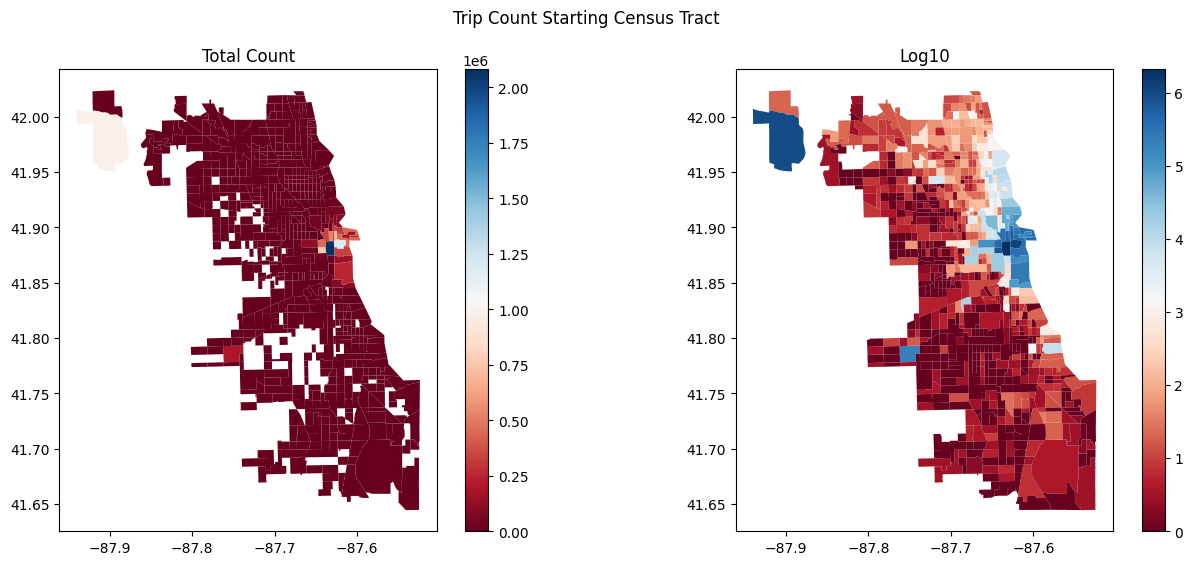

In [22]:
#transform pickup count 
trip_counts["pickup_count_log10"] = trip_counts['pickup_count'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Trip Count Starting Census Tract')
plot_locations(trip_counts, ax, 'pickup_count', 1, "Total Count")
plot_locations(trip_counts, ax, 'pickup_count_log10', 2, "Log10")


There seems to be a drastic difference in the number of trips when comparing the city centre and the outer city (excluding the airport). The next figure uses the trip counts on a logarithmic scale to be able to better differentiate the busyness in the outer census tracts.

In [23]:
# get how many percentage of rides top ten census tracts are 
(trip_counts.nlargest(10, "pickup_count")["pickup_count"].sum()/trip_counts["pickup_count"].sum()) * 100
#they make up almost 75% of all trips

72.12471024951621

#### Trip Length Analysis (Per Census Tract)

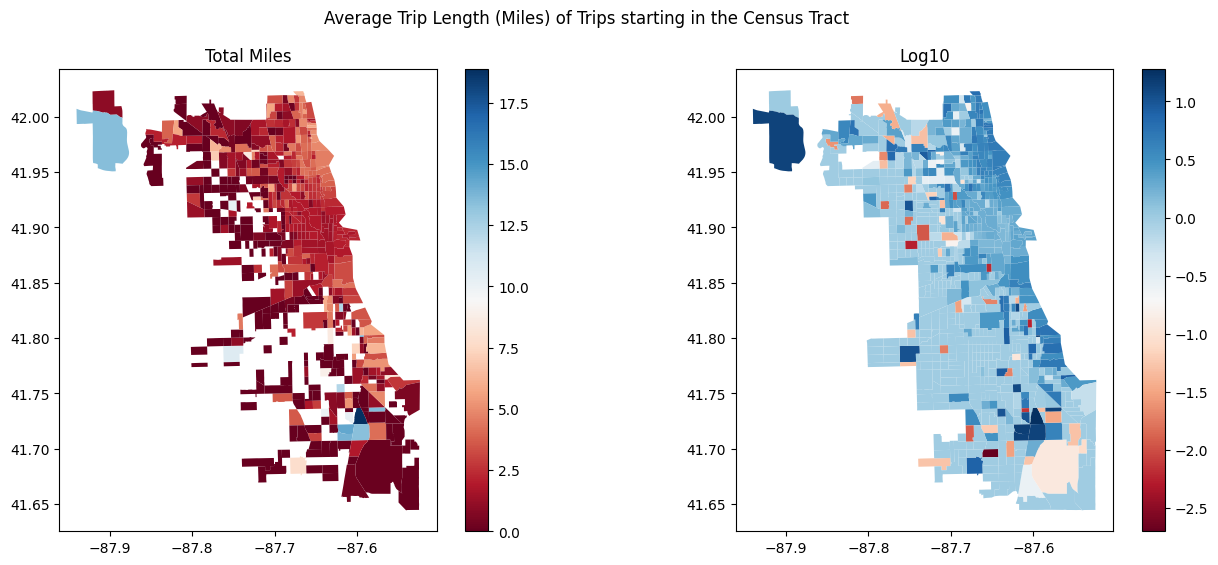

In [24]:
# Calculate average trip length per pickup census tract
average_trip_length_per_tract = taxi_trips_df.groupby('Pickup Census Tract')['Trip Miles'].mean().reset_index()
average_trip_length_per_tract = pd.merge(census_tracts, average_trip_length_per_tract, left_on="geo_id", right_on='Pickup Census Tract', how='left')
average_trip_length_per_tract = gpd.GeoDataFrame(average_trip_length_per_tract, geometry="geometry")

# Rename the column for clarity
average_trip_length_per_tract.rename(columns={'Trip Miles': 'average_trip_length'}, inplace=True)

# Apply log10 transformation (handling cases where average_trip_length is 0 or negative)
average_trip_length_per_tract["average_trip_length_log10"] = average_trip_length_per_tract['average_trip_length'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Trip Length (Miles) of Trips starting in the Census Tract')

plot_locations(average_trip_length_per_tract, ax, 'average_trip_length', 1, "Total Miles")
plot_locations(average_trip_length_per_tract, ax, 'average_trip_length_log10', 2, "Log10")


Max, Min Average Trip Length

In [25]:
print(f"maximum average trip length in miles for a census tract: {average_trip_length_per_tract['average_trip_length'].max()}\naverage trip length in miles for all census tracts: {average_trip_length_per_tract['average_trip_length'].mean()}\nminimum average trip length in miles for a census tract: {average_trip_length_per_tract['average_trip_length'].min()}")

maximum average trip length in miles for a census tract: 18.865000000000002
average trip length in miles for all census tracts: 2.0604475614006192
minimum average trip length in miles for a census tract: 0.0


#### Idle Time Analysis (Per Census Tract)

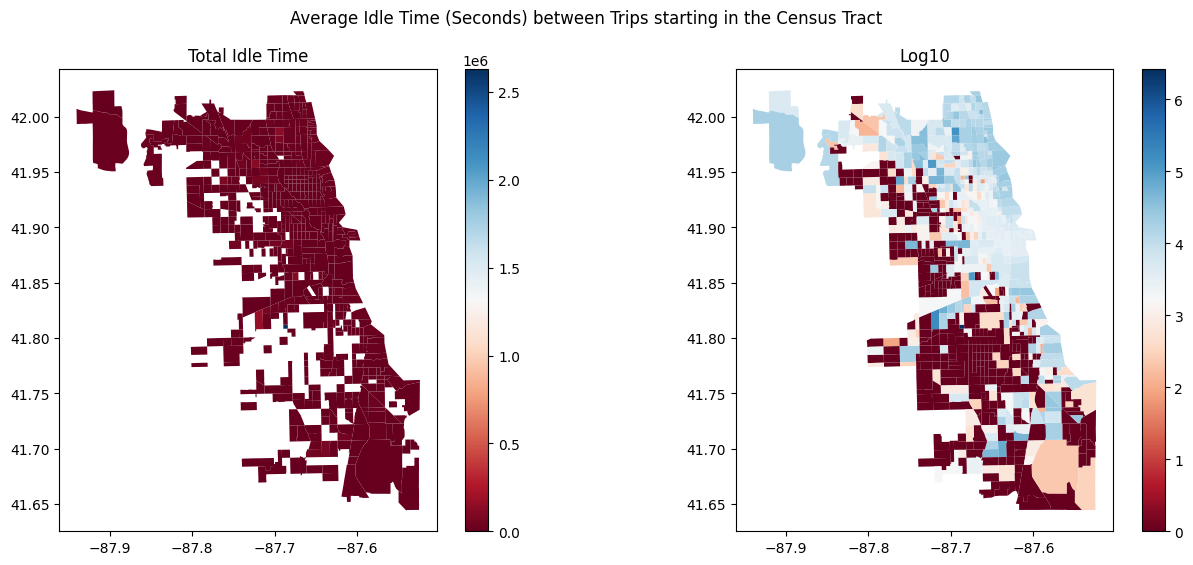

In [26]:
# Calculate average trip length per pickup census tract
average_idle_time_per_tract = taxi_trips_df.groupby('Pickup Census Tract')['idle_seconds'].mean().reset_index()
average_idle_time_per_tract = pd.merge(census_tracts, average_idle_time_per_tract, left_on="geo_id", right_on='Pickup Census Tract', how='left')
average_idle_time_per_tract = gpd.GeoDataFrame(average_idle_time_per_tract, geometry="geometry")

# Rename the column for clarity
average_idle_time_per_tract.rename(columns={'idle_seconds': 'average_idle_time'}, inplace=True)

# Apply log10 transformation (handling cases where average_trip_length is 0 or negative)
average_idle_time_per_tract["average_idle_time_log10"] = average_idle_time_per_tract['average_idle_time'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Idle Time (Seconds) between Trips starting in the Census Tract')

plot_locations(average_idle_time_per_tract, ax, 'average_idle_time', 1, "Total Idle Time")
plot_locations(average_idle_time_per_tract, ax, 'average_idle_time_log10', 2, "Log10")

Max. Min, Avg Idle Time

In [27]:
print(f"maximum average trip length in miles for a census tract: {average_idle_time_per_tract['average_idle_time'].max()}\naverage trip length in miles for all census tracts: {average_idle_time_per_tract['average_idle_time'].mean()}\nminimum average trip length in miles for a census tract: {average_idle_time_per_tract['average_idle_time'].min()}")

maximum average trip length in miles for a census tract: 2630025.0
average trip length in miles for all census tracts: 13071.445857059067
minimum average trip length in miles for a census tract: 0.0


#### Trip Seconds Analysis

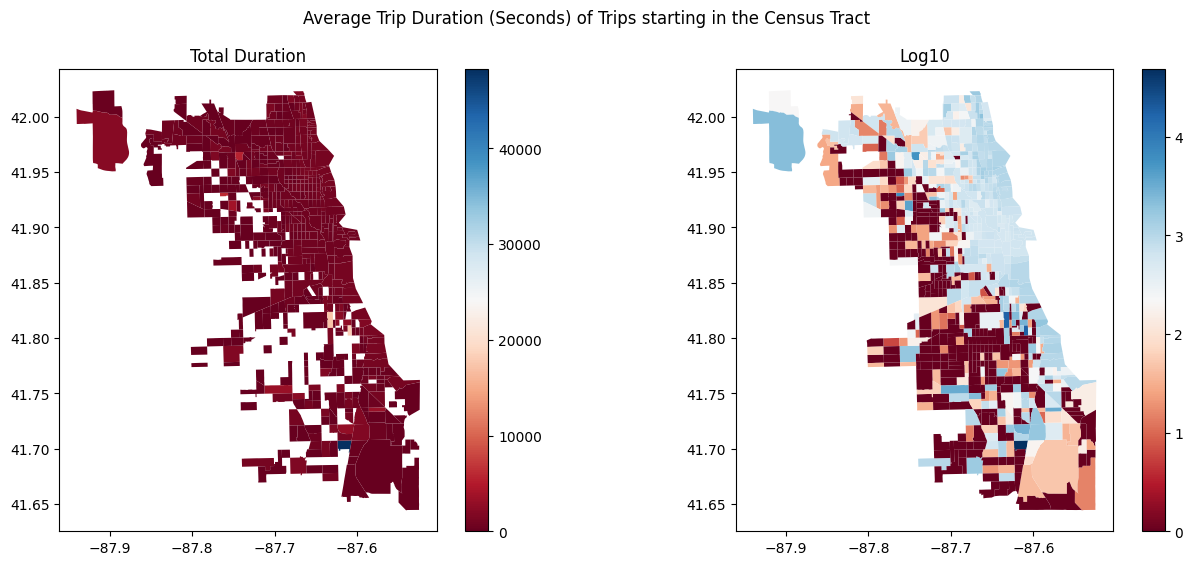

In [28]:
# Calculate average trip duration per pickup census tract
average_trip_duration_per_tract = taxi_trips_df.groupby('Pickup Census Tract')['Trip Seconds'].mean().reset_index()

# Merge with census_tracts GeoDataFrame
average_trip_duration_per_tract = pd.merge(census_tracts, average_trip_duration_per_tract, left_on="geo_id", right_on='Pickup Census Tract', how='left')

# Convert to GeoDataFrame (if not already)
average_trip_duration_per_tract = gpd.GeoDataFrame(average_trip_duration_per_tract, geometry="geometry")

# Rename the column for clarity
average_trip_duration_per_tract.rename(columns={'Trip Seconds': 'average_trip_duration'}, inplace=True)

# Apply log10 transformation (handling cases where average_trip_duration is 0 or negative)
average_trip_duration_per_tract["average_trip_duration_log10"] = average_trip_duration_per_tract['average_trip_duration'].apply(lambda x: np.log10(x) if x > 0 else 0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

fig.suptitle('Average Trip Duration (Seconds) of Trips starting in the Census Tract')

# Assuming plot_locations function is defined as before
plot_locations(average_trip_duration_per_tract, ax, 'average_trip_duration', 1, "Total Duration")
plot_locations(average_trip_duration_per_tract, ax, 'average_trip_duration_log10', 2, "Log10")



#### Dropoff Location Analysis

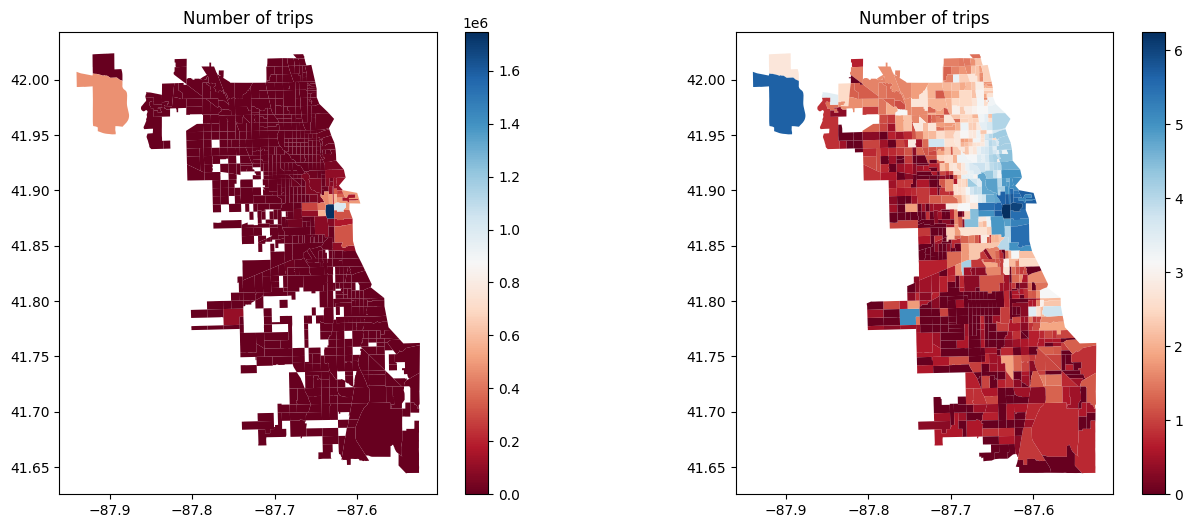

In [29]:
trip_counts["dropoff_count_log10"] = trip_counts['dropoff_count'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_locations(trip_counts, ax, 'dropoff_count', 1, "Number of trips")
plot_locations(trip_counts, ax, 'dropoff_count_log10', 2, "Number of trips")

In [163]:
get_basic_info_about_feature('dropoff_count')

maximum number of trips in a census tract: 1744878.0
average number of trips in a census tract: 16769.967032967033
minimum number of trips in a census tract: 1.0
number of tracts without a trip start: 164


In [30]:
# get how many percentage of rides top ten census tracts are 
(trip_counts.nlargest(10, "dropoff_count")["dropoff_count"].sum()/trip_counts["dropoff_count"].sum()) * 100
#they make up almost 61% of all trips
#the destinations seem to be more diverse than the starting points

61.848192585440685

### Trip Ratio Analysis

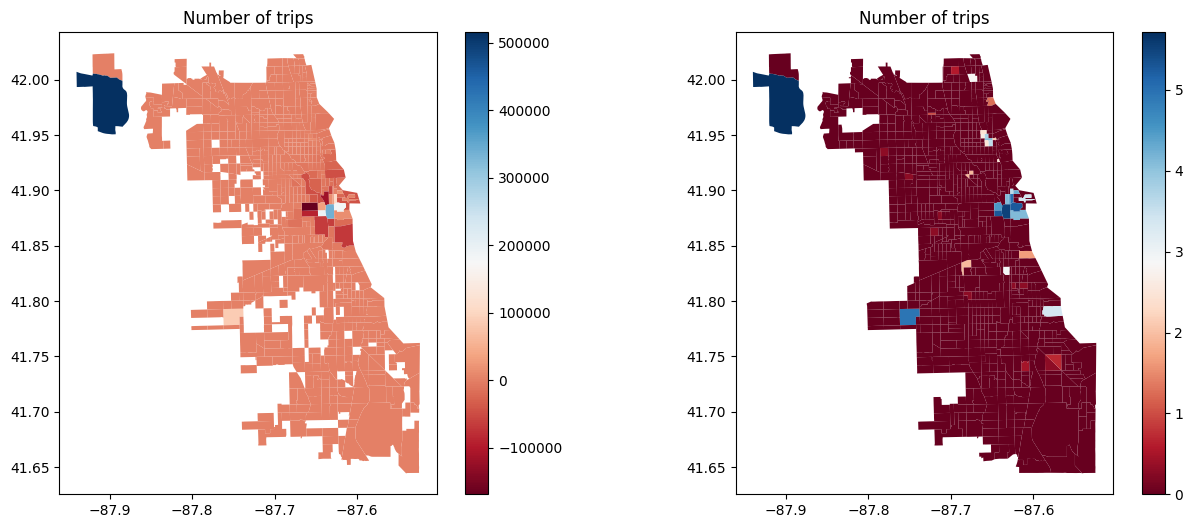

In [31]:
# show if census tract is rather a starting or end point 
# make dropoff negative and sum both columns up in "trip_total" for census tracts 
trip_counts['trips_ratio'] = trip_counts['pickup_count'] - trip_counts['dropoff_count']
trip_counts["ratio_log10"] = trip_counts['trips_ratio'].apply(lambda x: np.log10(x) if x > 0 else 0)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plot_locations(trip_counts, ax, 'trips_ratio', 1, "Number of trips")
plot_locations(trip_counts, ax, 'ratio_log10', 2, "Number of trips")


### H3 Hexagons

In [32]:
#sum for each resolution the pickup und dropoff count
trip_counts_h3 = trip_counts
for i in range (4,10):
    for j in ['pickup', 'dropoff']:
        trip_counts_h3[f'{j}_count_{i}'] = trip_counts_h3.groupby(f'h3_{i}')[f'{j}_count'].transform('sum')# 

# # #show final results
trip_counts_h3.head()

,geo_id,census_tract_short,geometry,centroids,h3_4,h3_5,h3_6,h3_7,h3_8,h3_9,...,pickup_count_5,dropoff_count_5,pickup_count_6,dropoff_count_6,pickup_count_7,dropoff_count_7,pickup_count_8,dropoff_count_8,pickup_count_9,dropoff_count_9
0,17031842400,8424,"MULTIPOLYGON (((-87.62405 41.73022, -87.62405 ...",POINT (-87.63004 41.74248),842664dffffffff,852664cffffffff,862664cdfffffff,872664cddffffff,882664cddbfffff,892664cddbbffff,...,126745.0,154568.0,100.0,182.0,31.0,79.0,26.0,73.0,26.0,73.0
1,17031840300,8403,"MULTIPOLYGON (((-87.68608 41.82296, -87.68607 ...",POINT (-87.68188 41.83209),842664dffffffff,852664cffffffff,862664cf7ffffff,872664cf2ffffff,882664cf21fffff,892664cf213ffff,...,126745.0,154568.0,114451.0,130326.0,14393.0,14313.0,14345.0,14254.0,14342.0,14251.0
2,17031841100,8411,"MULTIPOLYGON (((-87.62935 41.85280, -87.62934 ...",POINT (-87.63510 41.85101),842664dffffffff,852664cffffffff,862664cf7ffffff,872664cf4ffffff,882664cf4bfffff,892664cf4afffff,...,126745.0,154568.0,114451.0,130326.0,1165.0,21533.0,786.0,9648.0,786.0,9648.0
3,17031841200,8412,"MULTIPOLYGON (((-87.68813 41.85569, -87.68816 ...",POINT (-87.68334 41.85556),842664dffffffff,852664cbfffffff,862664cf7ffffff,872664cf6ffffff,882664cf65fffff,892664cf653ffff,...,181191.0,554012.0,114451.0,130326.0,23.0,319.0,3.0,19.0,3.0,19.0
4,17031839000,8390,"MULTIPOLYGON (((-87.63312 41.87449, -87.63306 ...",POINT (-87.63140 41.87104),842664dffffffff,852664c3fffffff,862664c1fffffff,872664c1affffff,882664c1a3fffff,892664c1a07ffff,...,9330614.0,9349415.0,8732059.0,8293130.0,2869226.0,2467163.0,7374.0,69455.0,7374.0,69455.0


In [33]:
for i in range(4,10):
    trip_counts_h3[f"pickup_count_log10_{i}"] = trip_counts_h3[f'pickup_count_{i}'].apply(lambda x: np.log10(x) if x > 0 else 0)
for i in range(4,10):
    trip_counts_h3[f"dropoff_count_log10_{i}"] = trip_counts_h3[f'dropoff_count_{i}'].apply(lambda x: np.log10(x) if x > 0 else 0)

### Pickup Analysis H3

In [34]:
def plot_locations_h3(data, ax, column, n_of_row, n_of_column, label): 
    """Function to plot geodata
    """
    data.plot(
    column=column,
    legend=True, 
    ax=ax[n_of_row-1][n_of_column-1],
    cmap='RdBu',
    legend_kwds={f'label': label},
)

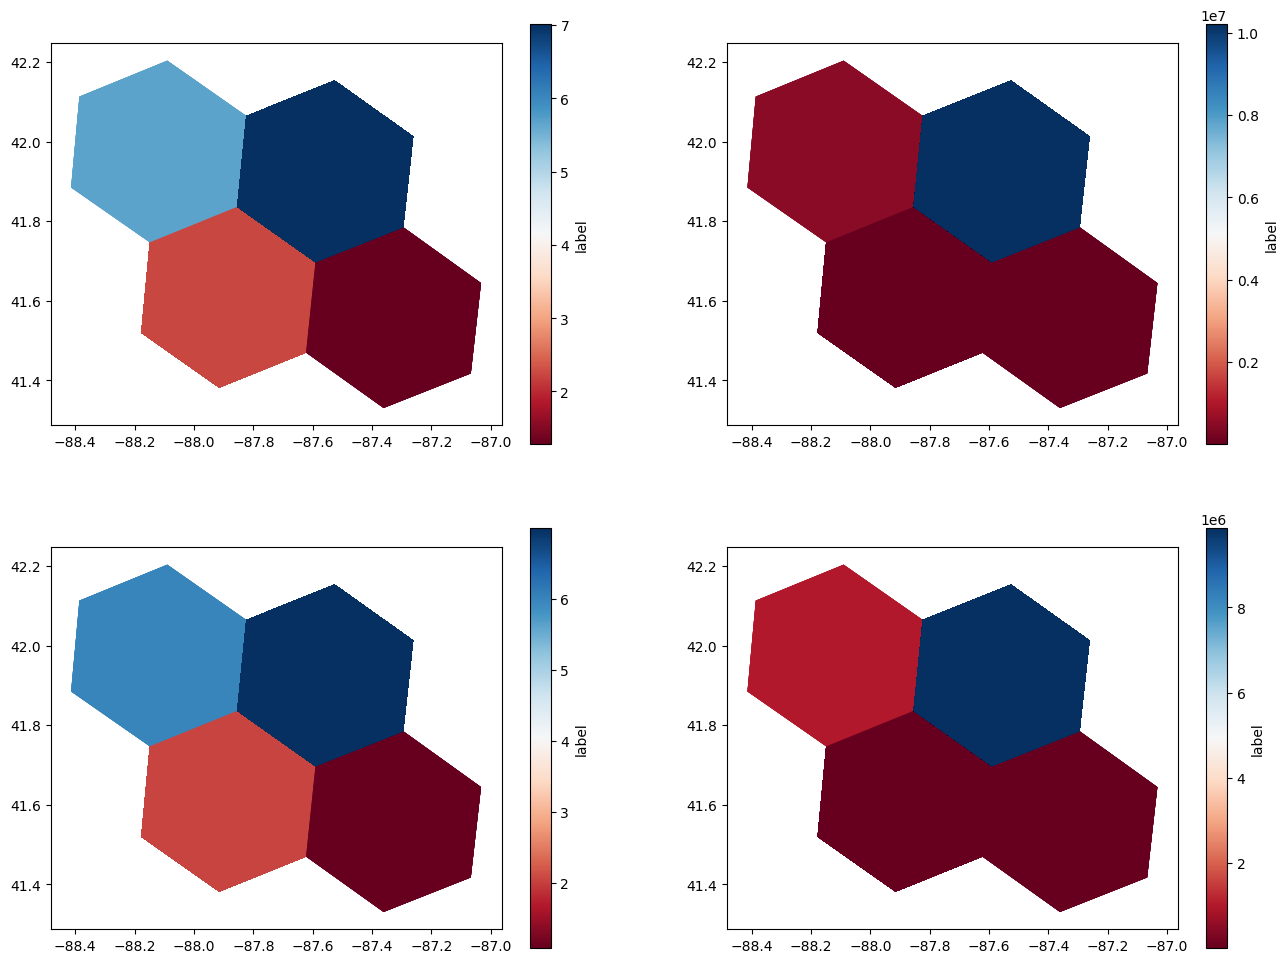

In [35]:
trips_4 = pd.DataFrame()
trips_4 = trip_counts_h3.filter(['h3_4', 'pickup_count_4', 'geometry', 'pickup_count_log10_4', 'dropoff_count_4', 'dropoff_count_log10_4'])
trips_4['geometry'] = trips_4.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_4"], geo_json=True)), axis=1)
trips_geo_4 = gpd.GeoDataFrame(trips_4, geometry=trips_4['geometry'], crs='EPSG:4326')

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_locations_h3(trips_geo_4, ax, 'pickup_count_4', 0, 0, 'label')
plot_locations_h3(trips_geo_4, ax, 'pickup_count_log10_4', 0, 1, 'label')
plot_locations_h3(trips_geo_4, ax, 'dropoff_count_4', 1, 0, 'label')
plot_locations_h3(trips_geo_4, ax, 'dropoff_count_log10_4', 1, 1, 'label')


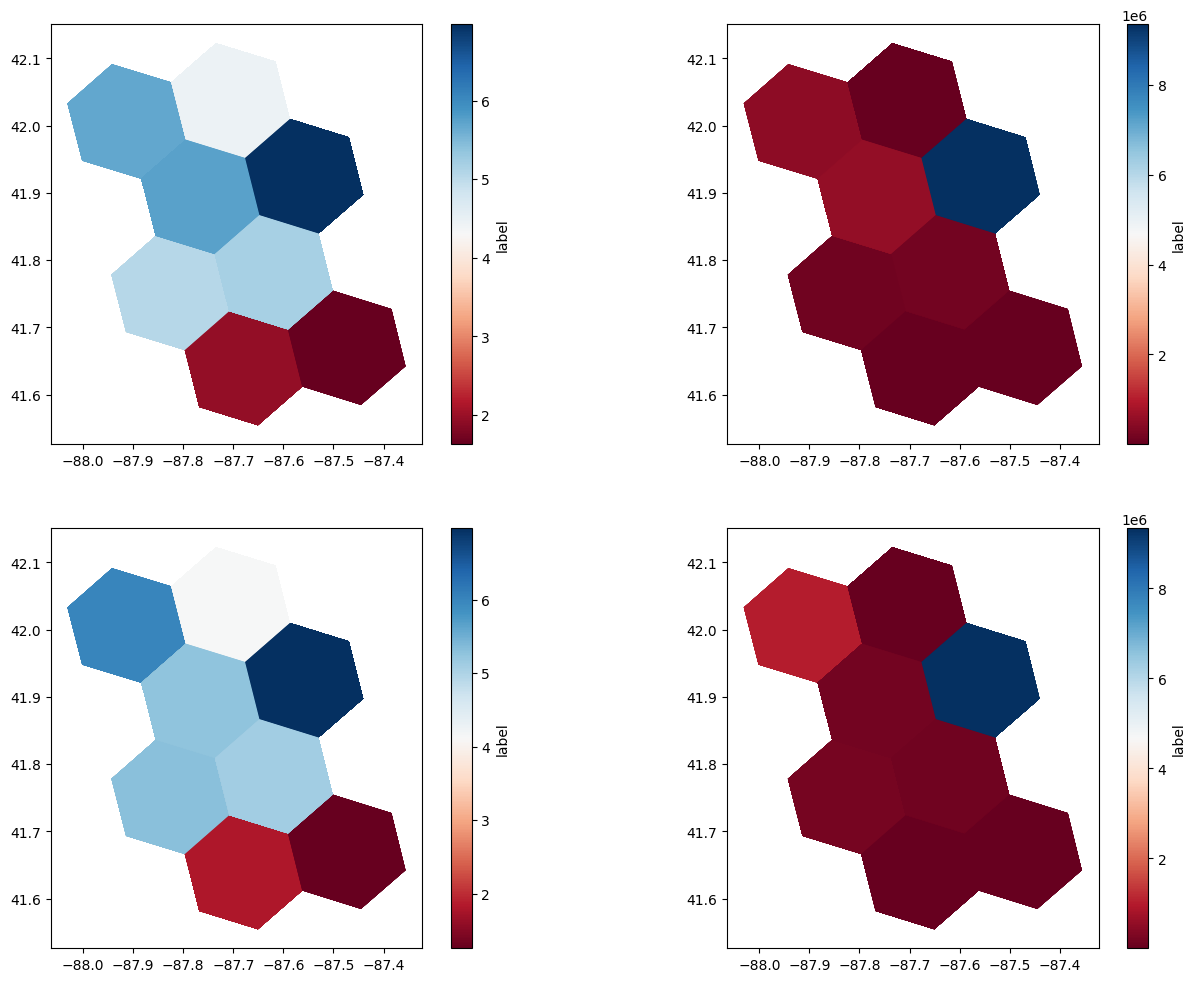

In [171]:
trips_pickup_5 = pd.DataFrame()
trips_pickup_5 = trip_counts_h3.filter(['h3_5', 'pickup_count_5', 'geometry', 'pickup_count_log10_5', 'dropoff_count_5', 'dropoff_count_log10_5'])
trips_pickup_5['geometry'] = trips_pickup_5.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_5"], geo_json=True)), axis=1)
trips_geo_5 = gpd.GeoDataFrame(trips_pickup_5, geometry=trips_pickup_5['geometry'], crs='EPSG:4326')

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_locations_h3(trips_geo_5, ax, 'pickup_count_5', 0, 0, 'label')
plot_locations_h3(trips_geo_5, ax, 'pickup_count_log10_5', 0, 1, 'label')
plot_locations_h3(trips_geo_5, ax, 'dropoff_count_5', 1, 0, 'label')
plot_locations_h3(trips_geo_5, ax, 'dropoff_count_log10_5', 1, 1, 'label')


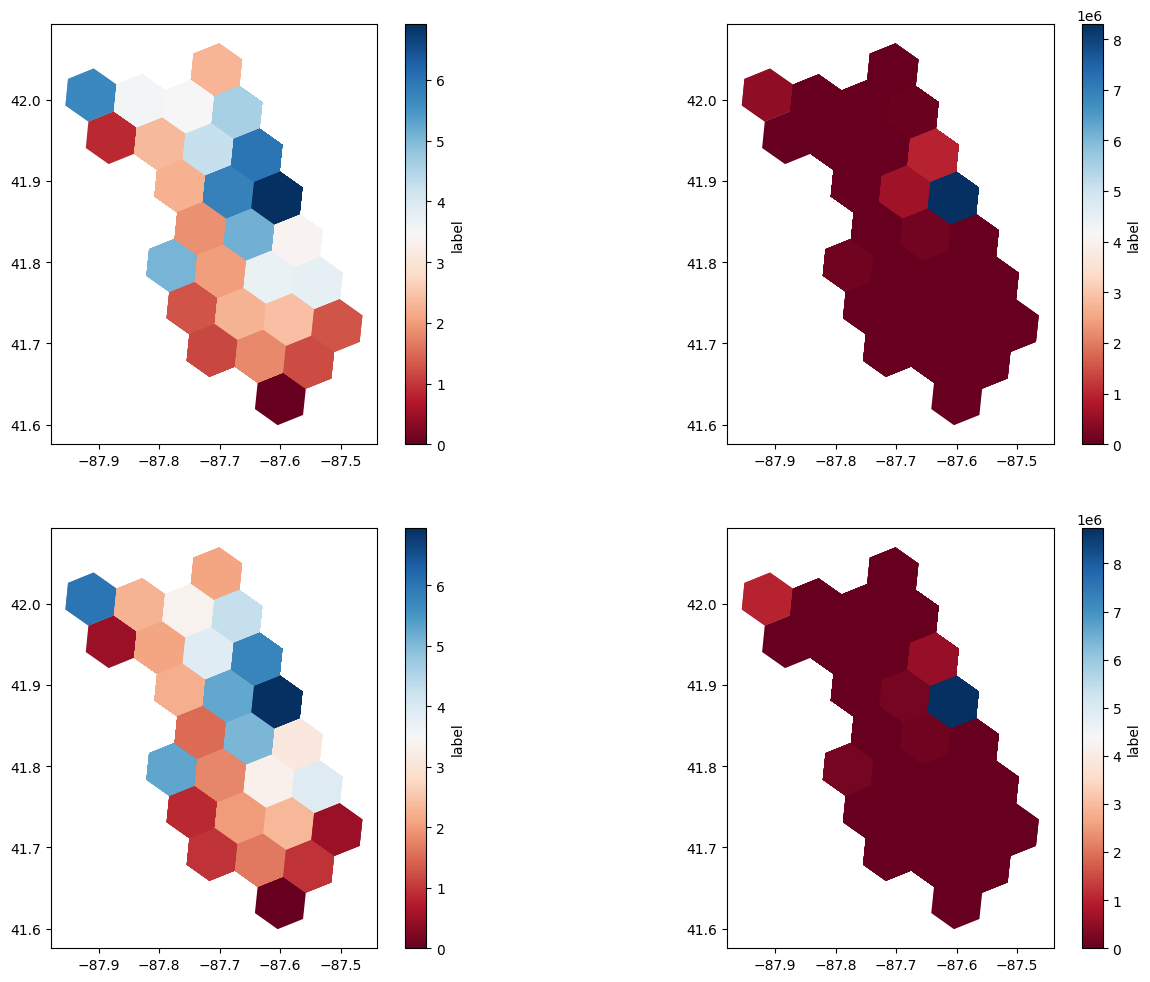

In [172]:

trips_pickup_6 = pd.DataFrame()
trips_pickup_6 = trip_counts_h3.filter(['h3_6', 'pickup_count_6', 'geometry', 'pickup_count_log10_6', 'dropoff_count_6', 'dropoff_count_log10_6'])
trips_pickup_6['geometry'] = trips_pickup_6.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_6"], geo_json=True)), axis=1)
trips_geo_6 = gpd.GeoDataFrame(trips_pickup_6, geometry=trips_pickup_6['geometry'], crs='EPSG:4326')

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_locations_h3(trips_geo_6, ax, 'pickup_count_6', 0, 0, 'label')
plot_locations_h3(trips_geo_6, ax, 'pickup_count_log10_6', 0, 1, 'label')
plot_locations_h3(trips_geo_6, ax, 'dropoff_count_6', 1, 0, 'label')
plot_locations_h3(trips_geo_6, ax, 'dropoff_count_log10_6', 1, 1, 'label')


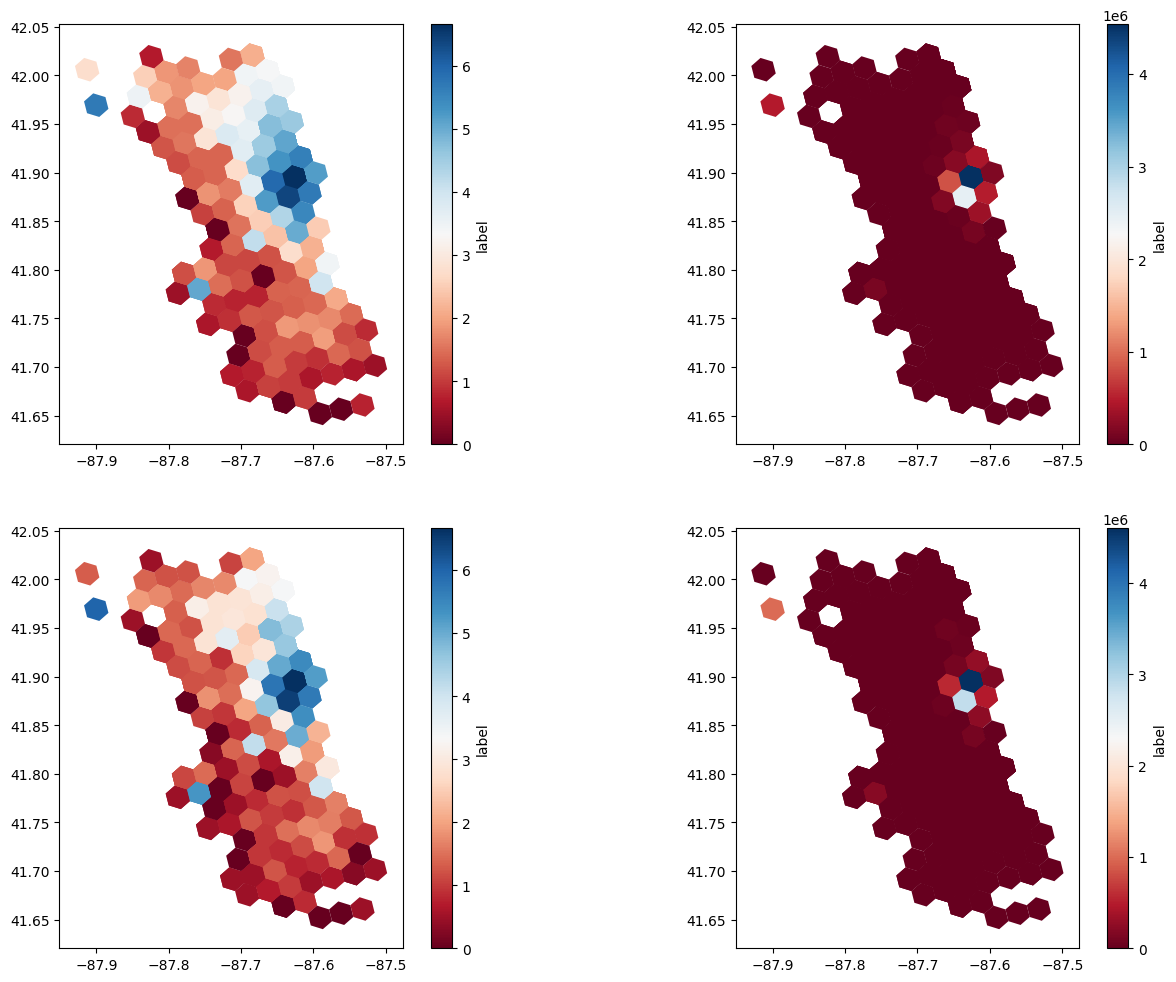

In [173]:
trips_pickup_7 = pd.DataFrame()
trips_pickup_7 = trip_counts_h3.filter(['h3_7', 'pickup_count_7', 'geometry', 'pickup_count_log10_7', 'dropoff_count_7', 'dropoff_count_log10_7'])
trips_pickup_7['geometry'] = trips_pickup_7.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_7"], geo_json=True)), axis=1)
trips_geo_7 = gpd.GeoDataFrame(trips_pickup_7, geometry=trips_pickup_7['geometry'], crs='EPSG:4326')

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_locations_h3(trips_geo_7, ax, 'pickup_count_7', 0, 0, 'label')
plot_locations_h3(trips_geo_7, ax, 'pickup_count_log10_7', 0, 1, 'label')
plot_locations_h3(trips_geo_7, ax, 'dropoff_count_7', 1, 0, 'label')
plot_locations_h3(trips_geo_7, ax, 'dropoff_count_log10_7', 1, 1, 'label')


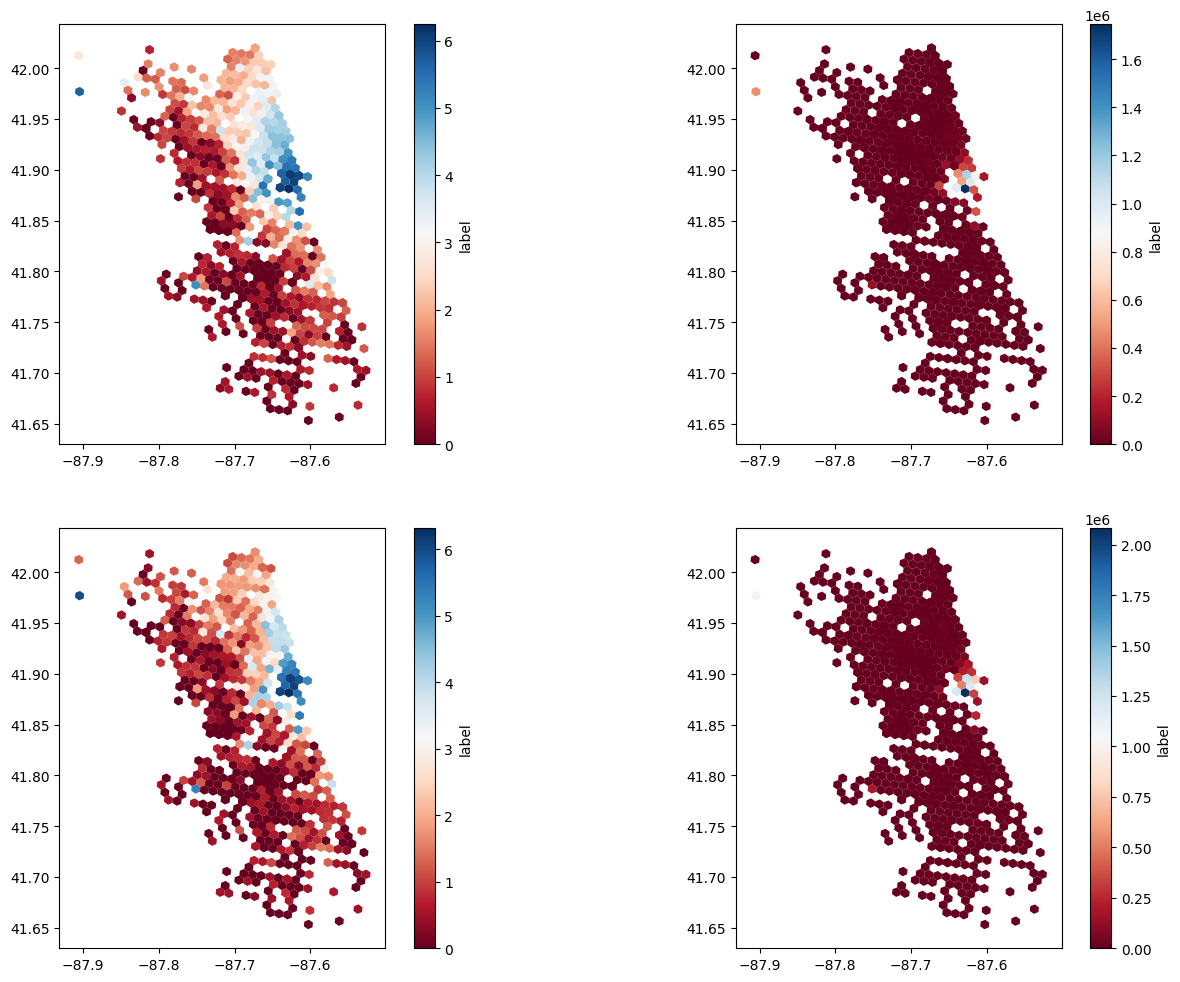

In [174]:
trips_pickup_8 = pd.DataFrame()
trips_pickup_8 = trip_counts_h3.filter(['h3_8', 'pickup_count_8', 'geometry', 'pickup_count_log10_8', 'dropoff_count_8', 'dropoff_count_log10_8'])
trips_pickup_8['geometry'] = trips_pickup_8.apply(lambda x: Polygon(h3.h3_to_geo_boundary(x["h3_8"], geo_json=True)), axis=1)
trips_geo_8 = gpd.GeoDataFrame(trips_pickup_8, geometry=trips_pickup_8['geometry'], crs='EPSG:4326')

fig, ax = plt.subplots(2, 2, figsize=(16, 12))

plot_locations_h3(trips_geo_8, ax, 'pickup_count_8', 0, 0, 'label')
plot_locations_h3(trips_geo_8, ax, 'pickup_count_log10_8', 0, 1, 'label')
plot_locations_h3(trips_geo_8, ax, 'dropoff_count_8', 1, 0, 'label')
plot_locations_h3(trips_geo_8, ax, 'dropoff_count_log10_8', 1, 1, 'label')


In [ ]:
#next todos 
#pickup dropoff als unterschiedliche kapitel 

#idle time per census tracts / hexagons
#trip length and dauer census tracts / hexagons
# wetter heatmap count rainy/sunny/temperature 
# 1 folium map 

# temporal analysis -> 

### Temporal Analysis

#### can be deleted once cleaned data is used ####

In [36]:
# takes about 2min
# split the start timestamp data into day / month / hour / day of week 
#this 
taxi_trips_df["start_hour"] = taxi_trips_df["Trip Start Timestamp"].apply(lambda x: x.hour)
taxi_trips_df["start_day"] = taxi_trips_df["Trip Start Timestamp"].apply(lambda x: x.day)
taxi_trips_df["start_month"] = taxi_trips_df["Trip Start Timestamp"].apply(lambda x: x.month)
taxi_trips_df["start_weekday"] = taxi_trips_df["Trip Start Timestamp"].apply(lambda x: x.dayofweek)

# split the end timestamp data into day / month / hour / day of week 
taxi_trips_df["end_hour"] = taxi_trips_df["Trip End Timestamp"].apply(lambda x: x.hour)
taxi_trips_df["end_day"] = taxi_trips_df["Trip End Timestamp"].apply(lambda x: x.day)
taxi_trips_df["end_month"] = taxi_trips_df["Trip End Timestamp"].apply(lambda x: x.month)
taxi_trips_df["end_weekday"] = taxi_trips_df["Trip End Timestamp"].apply(lambda x: x.dayofweek)

#### Calculation of Different Temporal Discretization 
TBD: Should this be done in the Data Preparation already?

In [37]:
# different temporal discretization (e.g., hourly, 4-hourly, daily) - hourly & daily already exists; bin start & end data into 4-hour intervals
bins = [0, 3, 7, 11, 15, 19, 23]
labels = [1,2,3,4,5,6]
taxi_trips_df["start_time_4_hour_interval"] = pd.cut(taxi_trips_df['start_hour'], bins=bins, labels=labels, include_lowest=True)
taxi_trips_df["end_time_4_hour_interval"] = pd.cut(taxi_trips_df['end_hour'], bins=bins, labels=labels, include_lowest=True)

#### Trips per Month Analysis

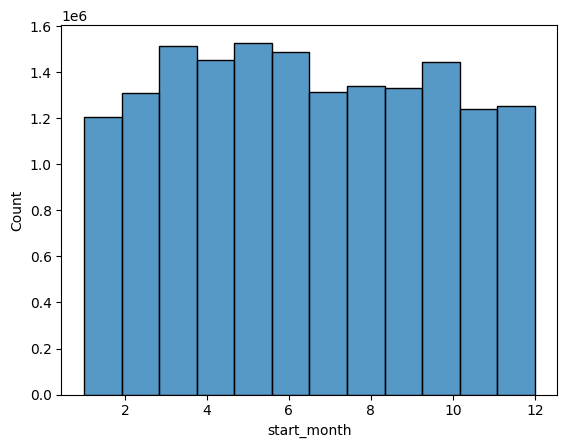

In [38]:
#look at trips per month [count, length (avg), idle time (avg), price (avg)]
plot = sns.histplot(data=taxi_trips_df, x="start_month", bins=12)

#### Trips per Weekday Analysis

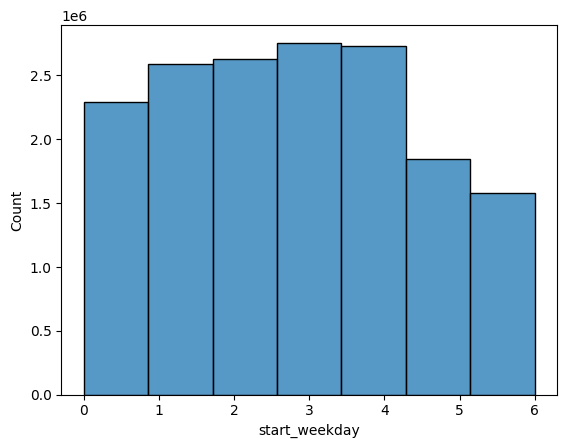

In [39]:
#look at trips per weekday [count, length (avg), idle time (avg), price (avg)]
plot = sns.histplot(data=taxi_trips_df, x="start_weekday", bins=7)

#### Trips per Daytime Analysis

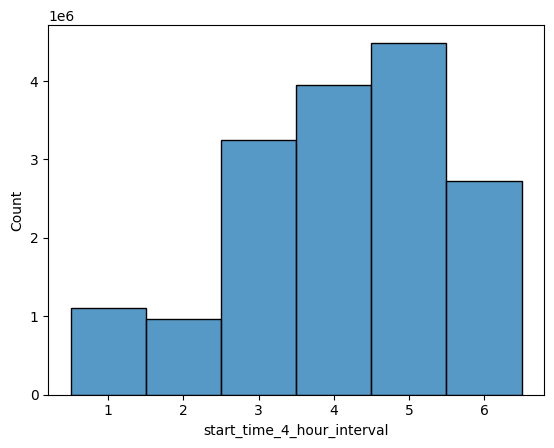

In [9]:
#look at trips per time in day (4h interval) [count, length (avg), idle time (avg), price (avg)]
plot = sns.histplot(data=taxi_trips_df, x="start_time_4_hour_interval", bins=6)

#### Weekday X Starttime Analysis 

/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_89345/3458331785.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df= taxi_trips_df.groupby(['start_weekday', 'start_time_4_hour_interval']).size().reset_index(name='count')


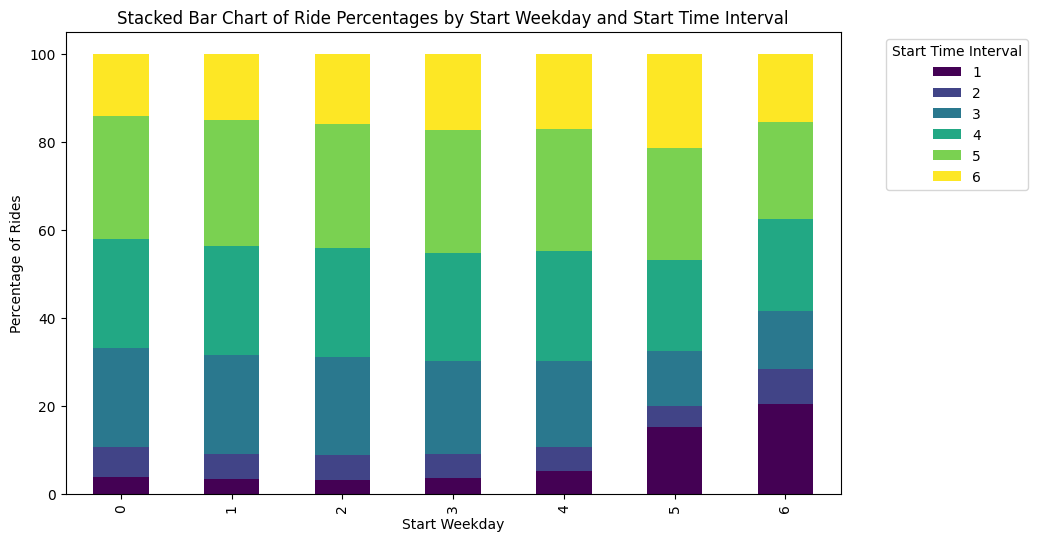

In [21]:
df= taxi_trips_df.groupby(['start_weekday', 'start_time_4_hour_interval']).size().reset_index(name='count')
pivot_df = df.pivot(index='start_weekday', columns='start_time_4_hour_interval', values='count')

# Normalize the counts to percentages
pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plotting the stacked bar chart with percentages
ax = pivot_df_percentage.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')

plt.xlabel('Start Weekday')
plt.ylabel('Percentage of Rides')
plt.title('Stacked Bar Chart of Ride Percentages by Start Weekday and Start Time Interval')
plt.legend(title='Start Time Interval', bbox_to_anchor=(1.05, 1), loc='upper left')

#### Hourly Trips Analysis

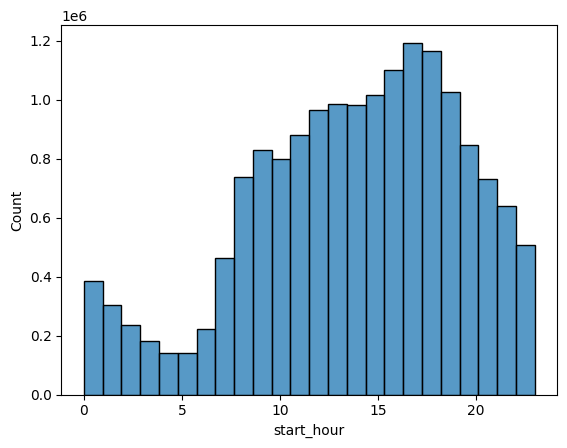

In [61]:
#trips per hour [count, length (avg), idle time (avg), price (avg)] 
#start histogram
plot = sns.histplot(data=taxi_trips_df, x="start_hour", bins=24)

### Point of Interest Analysis

In [40]:
#import POI data
poi_data = gpd.read_file(f'POI_data.geojson')
poi_data.head()

,Address,Longitude,Latitude,Category,geometry
0,5739-5741 N RAVENSWOOD AVE 1ST,-87.674541,41.986231,Bar/ Night Club,POINT (-87.67454 41.98623)
1,7 W DIVISION ST 1,-87.628992,41.903827,Bar/ Night Club,POINT (-87.62899 41.90383)
2,1140 W WILSON AVE,-87.659159,41.965489,Bar/ Night Club,POINT (-87.65916 41.96549)
3,1332 N HALSTED ST 1ST/M,-87.648292,41.906038,Bar/ Night Club,POINT (-87.64829 41.90604)
4,5338 N LINCOLN AVE 1,-87.692789,41.978854,Bar/ Night Club,POINT (-87.69279 41.97885)


In [46]:
loc = 'Points of interest within census tract borders'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(loc)   

m = folium.Map(location=(41.8,-87.723177), zoom_start=11)

# Define different marker types or icons for different categories
category_markers = {
    'Bar/ Night Club': 'info-sign', 
    'Hotel': 'cloud',      
    'Stadium': 'star',
    'Airport': 'airplane'      
}

# Iterate through the poi_data and add markers to the map
for idx, row in poi_data.iterrows():
    category = row['Category']
    icon = category_markers.get(category, 'ok-sign')  
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        icon=folium.Icon(icon=icon, color='blue'),  
        tooltip=row['Category']  # Show category on hover
    ).add_to(m)

m.get_root().html.add_child(folium.Element(title_html))
# Interactive map
poi_data.explore(tooltip=True, cmap="viridis", m = m, style_kwds = {"opacity": 0.3, "red": "red", "fillOpacity": 0.3, "fillColor": 'red'}, marker_kwds = {"radius": 3})

In [180]:
#count number of POI per census tract
# Ensure both GeoDataFrames are in the same CRS
if poi_data.crs != census_tracts.crs:
    poi_data = poi_data.to_crs(census_tracts.crs)

# Perform the spatial join
# This joins the POIs to the census tracts, adding the tract data to the POIs
joined = gpd.sjoin(poi_data, census_tracts, how='left', op='within')

/Users/mmuenk/Documents/Information Systems/Sommersemester 2024/Advanced Analytics and Applications/Project - Chicago 2019/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3490: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,Address,Longitude,Latitude,Category,geometry,index_right,geo_id,census_tract_short,centroids,h3_4,h3_5,h3_6,h3_7,h3_8,h3_9
0,5739-5741 N RAVENSWOOD AVE 1ST,-87.674541,41.986231,Bar/ Night Club,POINT (-87.67454 41.98623),551,17031030400,304,POINT (-87.67208 41.98695),842664dffffffff,852664dbfffffff,862664d8fffffff,872664d88ffffff,882664d881fffff,892664d8813ffff
1,7 W DIVISION ST 1,-87.628992,41.903827,Bar/ Night Club,POINT (-87.62899 41.90383),239,17031081100,811,POINT (-87.62911 41.90021),842664dffffffff,852664c3fffffff,862664c1fffffff,872664c1effffff,882664c1edfffff,892664c1ec7ffff
2,1140 W WILSON AVE,-87.659159,41.965489,Bar/ Night Club,POINT (-87.65916 41.96549),250,17031830700,8307,POINT (-87.65917 41.96097),842664dffffffff,852664c3fffffff,862664d8fffffff,872664d89ffffff,882664d897fffff,892664d8963ffff
3,1332 N HALSTED ST 1ST/M,-87.648292,41.906038,Bar/ Night Club,POINT (-87.64829 41.90604),110,17031842200,8422,POINT (-87.64989 41.90493),842664dffffffff,852664c3fffffff,862664c17ffffff,872664c13ffffff,882664c137fffff,892664c1377ffff
4,5338 N LINCOLN AVE 1,-87.692789,41.978854,Bar/ Night Club,POINT (-87.69279 41.97885),28,17031040202,402.02,POINT (-87.69410 41.97985),842664dffffffff,852664dbfffffff,862664d8fffffff,872664d8affffff,882664d8abfffff,892664d8aabffff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,633 N ST CLAIR ST 1-17,-87.622575,41.893475,Hotel,POINT (-87.62257 41.89348),164,17031081401,814.01,POINT (-87.61975 41.89504),842664dffffffff,852664c3fffffff,862664c1fffffff,872664c1effffff,882664c1ebfffff,892664c1eabffff
1165,1600-1618 N MILWAUKEE AVE 1-13,-87.677761,41.910437,Hotel,POINT (-87.67776 41.91044),307,17031240500,2405,POINT (-87.68364 41.91197),842664dffffffff,852664cbfffffff,862664cafffffff,872664cacffffff,882664cacdfffff,892664caccfffff
1166,1 S FRANKLIN ST 1-9,-87.635164,41.881903,Hotel,POINT (-87.63516 41.88190),96,17031839100,8391,POINT (-87.63275 41.88103),842664dffffffff,852664c3fffffff,862664c1fffffff,872664c1affffff,882664c1a9fffff,892664c1a8bffff
1167,233 E ONTARIO ST 1-16,-87.621812,41.893265,Hotel,POINT (-87.62181 41.89327),165,17031081403,814.03,POINT (-87.60997 41.89191),842664dffffffff,852664c3fffffff,862664c1fffffff,872664c1effffff,882664c1ebfffff,892664c1ea7ffff


In [187]:
#get poi count per census tract
poi_per_census_tract_category = joined.groupby(['geo_id', 'Category']).size().reset_index(name='poi_count')

,geo_id,Category,poi_count
0,17031010201,Bar/ Night Club,1
1,17031010300,Bar/ Night Club,3
2,17031010300,Hotel,1
3,17031010400,Bar/ Night Club,1
4,17031010503,Bar/ Night Club,1
...,...,...,...
489,17031843700,Bar/ Night Club,1
490,17031843700,Stadium,1
491,17031980000,Airport,1
492,17031980100,Airport,1


/var/folders/08/b9r9d3452g14mtvjlk6mrgb80000gn/T/ipykernel_2700/3965398226.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Category', y='poi_count', data=category_totals, palette='viridis')


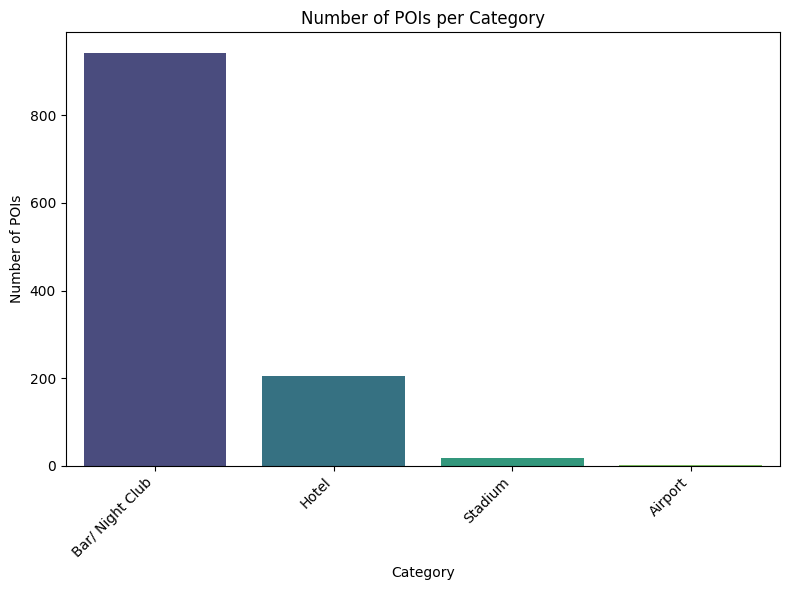

In [192]:
#barplot to show how many there are of each category (and which categories exist)
# Group by 'Category' and sum the 'poi_count' to get the total count for each category
category_totals = poi_per_census_tract_category.groupby('Category')['poi_count'].sum().reset_index()

# Sort the categories by the count for better visualization
category_totals = category_totals.sort_values('poi_count', ascending=False)

# Plotting the bar plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='Category', y='poi_count', data=category_totals, palette='viridis')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability if necessary
plt.xlabel('Category')
plt.ylabel('Number of POIs')
plt.title('Number of POIs per Category')
plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

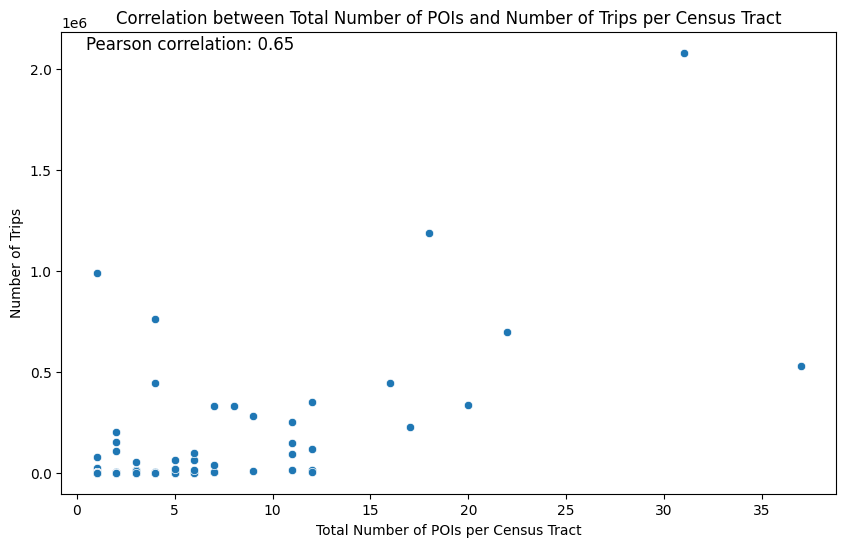

In [195]:
from scipy.stats import pearsonr

#look at how the number of point of interests correlates with the trip count
pois_per_census_tract = poi_per_census_tract_category.groupby('geo_id')['poi_count'].sum().reset_index()
pois_per_census_tract.columns = ['geo_id', 'total_poi_count']

merged_data = pd.merge(pois_per_census_tract, trip_counts, on='geo_id')

merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate and display Pearson correlation coefficient
correlation, _ = pearsonr(merged_data['total_poi_count'], merged_data['pickup_count'])


In [ ]:
#What needs to be improved in the above section: (I (Milena) can do this after I submitted my seminar paper on the 21st of July)
 #   analysis of the results
  #  title of visualizations
   # map of chicago in the background of hexagons
    # scale of y-axis 
    # function for creating plots needs to be improved (especially for hexagons)
# write function for aggregating data
# depict areas with no values in grey

In [ ]:
# next todos 
#incorporate weather data
#maybe some temporal x spatial combination
#idea: feiertage/ferien? 

### IMPORTANT ###
# The code needs to be run on the cleaned data. The cleaned data file needs some adjustments for that